### IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
import logging
import time

logging.getLogger('lightgbm').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

### DATA LOADING

In [2]:
print("\n" + "LOADING DATASETS")
print("="*80)

BASE_DIR = '/kaggle/input/Cinema_Audience_Forecasting_challenge/'

booknow_visits = pd.read_csv(BASE_DIR + 'booknow_visits/booknow_visits.csv', parse_dates=["show_date"])
booknow_booking = pd.read_csv(BASE_DIR + 'booknow_booking/booknow_booking.csv', parse_dates=["show_datetime", "booking_datetime"])
cinePOS_booking = pd.read_csv(BASE_DIR + 'cinePOS_booking/cinePOS_booking.csv', parse_dates=["show_datetime", "booking_datetime"])
booknow_theaters = pd.read_csv(BASE_DIR + 'booknow_theaters/booknow_theaters.csv')
cinePOS_theaters = pd.read_csv(BASE_DIR + 'cinePOS_theaters/cinePOS_theaters.csv')
date_info = pd.read_csv(BASE_DIR + 'date_info/date_info.csv', parse_dates=["show_date"])
sample_submission = pd.read_csv(BASE_DIR + 'sample_submission/sample_submission.csv') 
movie_theater_id_relation = pd.read_csv(BASE_DIR + 'movie_theater_id_relation/movie_theater_id_relation.csv')

print("Data loaded successfully.")


LOADING DATASETS
Data loaded successfully.


### DATA CLEANING

In [3]:
print("\n" + "DATASET OVERVIEW")
print("="*80)

def data_report(df, name):
    print(f'\n--- {name.upper()} ---') 
    print('\nShape:', df.shape)  
    print('Columns:', df.columns.tolist()) 
    print('Missing values:', df.isnull().sum().sum()) 
    print("\nUnique Value Counts:")
    print(df.nunique())
    print("\n")
    display(df.info())  

data_report(booknow_visits, 'booknow_visits')
data_report(booknow_booking, 'booknow_booking')
data_report(cinePOS_booking, 'cinePOS_booking')
data_report(booknow_theaters, 'booknow_theaters')
data_report(cinePOS_theaters, 'cinePOS_theaters')
data_report(date_info, 'date_info')
data_report(movie_theater_id_relation, 'movie_theater_id_relation')
data_report(sample_submission, 'sample_submission')


DATASET OVERVIEW

--- BOOKNOW_VISITS ---

Shape: (214046, 3)
Columns: ['book_theater_id', 'show_date', 'audience_count']
Missing values: 0

Unique Value Counts:
book_theater_id    826
show_date          424
audience_count     191
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   book_theater_id  214046 non-null  object        
 1   show_date        214046 non-null  datetime64[ns]
 2   audience_count   214046 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.9+ MB


None


--- BOOKNOW_BOOKING ---

Shape: (68336, 4)
Columns: ['book_theater_id', 'show_datetime', 'booking_datetime', 'tickets_booked']
Missing values: 0

Unique Value Counts:
book_theater_id      301
show_datetime       3866
booking_datetime    6351
tickets_booked        66
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68336 entries, 0 to 68335
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   book_theater_id   68336 non-null  object        
 1   show_datetime     68336 non-null  datetime64[ns]
 2   booking_datetime  68336 non-null  datetime64[ns]
 3   tickets_booked    68336 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 2.1+ MB


None


--- CINEPOS_BOOKING ---

Shape: (1641966, 4)
Columns: ['cine_theater_id', 'show_datetime', 'booking_datetime', 'tickets_sold']
Missing values: 0

Unique Value Counts:
cine_theater_id     13161
show_datetime        8283
booking_datetime    10152
tickets_sold           97
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641966 entries, 0 to 1641965
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   cine_theater_id   1641966 non-null  object        
 1   show_datetime     1641966 non-null  datetime64[ns]
 2   booking_datetime  1641966 non-null  datetime64[ns]
 3   tickets_sold      1641966 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 50.1+ MB


None


--- BOOKNOW_THEATERS ---

Shape: (829, 5)
Columns: ['book_theater_id', 'theater_type', 'theater_area', 'latitude', 'longitude']
Missing values: 515

Unique Value Counts:
book_theater_id    314
theater_type         4
theater_area       103
latitude           108
longitude          108
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   book_theater_id  314 non-null    object 
 1   theater_type     829 non-null    object 
 2   theater_area     829 non-null    object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


None


--- CINEPOS_THEATERS ---

Shape: (4690, 5)
Columns: ['cine_theater_id', 'theater_type', 'theater_area', 'latitude', 'longitude']
Missing values: 7722

Unique Value Counts:
cine_theater_id    4690
theater_type          3
theater_area        119
latitude            108
longitude           108
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cine_theater_id  4690 non-null   object 
 1   theater_type     4690 non-null   object 
 2   theater_area     4690 non-null   object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


None


--- DATE_INFO ---

Shape: (547, 2)
Columns: ['show_date', 'day_of_week']
Missing values: 0

Unique Value Counts:
show_date      547
day_of_week      7
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   show_date    547 non-null    datetime64[ns]
 1   day_of_week  547 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 8.7+ KB


None


--- MOVIE_THEATER_ID_RELATION ---

Shape: (150, 2)
Columns: ['book_theater_id', 'cine_theater_id']
Missing values: 0

Unique Value Counts:
book_theater_id    150
cine_theater_id    150
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   book_theater_id  150 non-null    object
 1   cine_theater_id  150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


None


--- SAMPLE_SUBMISSION ---

Shape: (38062, 2)
Columns: ['ID', 'audience_count']
Missing values: 0

Unique Value Counts:
ID                38062
audience_count        1
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              38062 non-null  object
 1   audience_count  38062 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 594.8+ KB


None

In [4]:
print("\n" + "DATA CLEANING")
print("="*80)

def clean_data(booknow_visits, booknow_booking, cinepos_booking, booknow_theaters, cinepos_theaters):
    booknow_theaters_cleaned = booknow_theaters.copy()
    cinepos_theaters_cleaned = cinepos_theaters.copy()
    booknow_visits_cleaned = booknow_visits.copy()
    cinepos_booking_cleaned = cinepos_booking.copy()
    booknow_booking_cleaned = booknow_booking.copy()
    
    # Dropping Nan rows 
    booknow_theaters_cleaned.dropna(subset=['book_theater_id'], inplace=True) # 829 rows to 314 rows. Dropping 515 rows which has missing ids
    
    # Dropping redundant cols
    booknow_theaters_cleaned.drop(columns=['latitude', 'longitude'], inplace=True) # Latitude and longitude are approximate values and location is already captured in theater area col. 
    cinepos_theaters_cleaned.drop(columns=['latitude', "longitude"], inplace=True)  

    # Remove duplicates
    booknow_visits_cleaned = booknow_visits.drop_duplicates() # 10 duplicates
    booknow_booking_cleaned = booknow_booking.drop_duplicates() # 2042 duplicates
    cinepos_booking_cleaned = cinepos_booking.drop_duplicates() # 12541 duplicates

    return (
        booknow_visits_cleaned,
        booknow_booking_cleaned,
        cinepos_booking_cleaned,
        booknow_theaters_cleaned,
        cinepos_theaters_cleaned,
    )

booknow_visits_cleaned, booknow_booking_cleaned, cinePOS_booking_cleaned, booknow_theaters_cleaned, cinePOS_theaters_cleaned = clean_data(booknow_visits, booknow_booking, cinePOS_booking, booknow_theaters, cinePOS_theaters) 

dfs = {
    "booknow_visits": [booknow_visits, booknow_visits_cleaned],
    "booknow_booking": [booknow_booking, booknow_booking_cleaned],
    "cinepos_booking": [cinePOS_booking, cinePOS_booking_cleaned],
    "booknow_theaters_cleaned": [booknow_theaters, booknow_theaters_cleaned],
    "cinepos_theaters_cleaned": [cinePOS_theaters, cinePOS_theaters_cleaned]
}
    
print("\nBefore Cleaning:")
for name, (before_df, after_df) in dfs.items():
    print(f"{name.upper()}: {before_df.duplicated().sum()} duplicates, Missing values: {before_df.isnull().sum().sum()}")

print("\nAfter Cleaning:")
for name, (before_df, after_df) in dfs.items():
    print(f"{name.upper()}: {after_df.duplicated().sum()} duplicates, Missing values: {after_df.isnull().sum().sum()}")

print("\nData cleaned successfully.")

# The date_info dataset only has day of week col which can be derived from date col. So not using this dataset.


DATA CLEANING

Before Cleaning:
BOOKNOW_VISITS: 10 duplicates, Missing values: 0
BOOKNOW_BOOKING: 2042 duplicates, Missing values: 0
CINEPOS_BOOKING: 12541 duplicates, Missing values: 0
BOOKNOW_THEATERS_CLEANED: 354 duplicates, Missing values: 515
CINEPOS_THEATERS_CLEANED: 0 duplicates, Missing values: 7722

After Cleaning:
BOOKNOW_VISITS: 0 duplicates, Missing values: 0
BOOKNOW_BOOKING: 0 duplicates, Missing values: 0
CINEPOS_BOOKING: 0 duplicates, Missing values: 0
BOOKNOW_THEATERS_CLEANED: 0 duplicates, Missing values: 0
CINEPOS_THEATERS_CLEANED: 0 duplicates, Missing values: 0

Data cleaned successfully.


### EDA


Visualizing daily audience counts


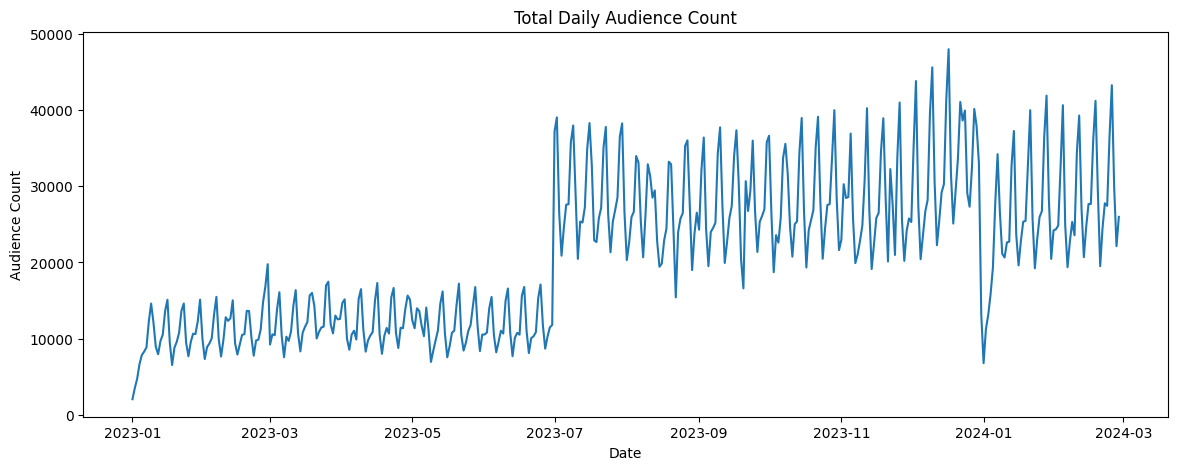


INSIGHTS:
----------------------------------------
From July 2023 to Dec 2023, there is rise in audience counts, maybe due to big movie releases
Audience counts rise and fall regularly but on average audience behaves consistently every week so weekly average is important to consider for modelling
Mostly audience counts reach the max of 20000 during normal days
In January there is a dip, but after that it again increases to even higher levels. It maybe seasonal effect


In [5]:
print("\n" + "Visualizing daily audience counts")
print("=" * 80)

# Visualizing daily audience counts
df = booknow_visits.copy()
df['show_date'] = pd.to_datetime(df['show_date'])
df_grouped = df.groupby('show_date')['audience_count'].sum().reset_index()
plt.figure(figsize=(14,5))
plt.plot(df_grouped['show_date'], df_grouped['audience_count'])
plt.title('Total Daily Audience Count')
plt.xlabel('Date')
plt.ylabel('Audience Count')
plt.show()

print("\nINSIGHTS:")
print("-" * 40)
print(f"From July 2023 to Dec 2023, there is rise in audience counts, maybe due to big movie releases")
print(f"Audience counts rise and fall regularly but on average audience behaves consistently every week so weekly average is important to consider for modelling")
print(f"Mostly audience counts reach the max of 20000 during normal days")
print(f"In January there is a dip, but after that it again increases to even higher levels. It maybe seasonal effect")


Visualizing the booking trends


<Figure size 1500x600 with 0 Axes>

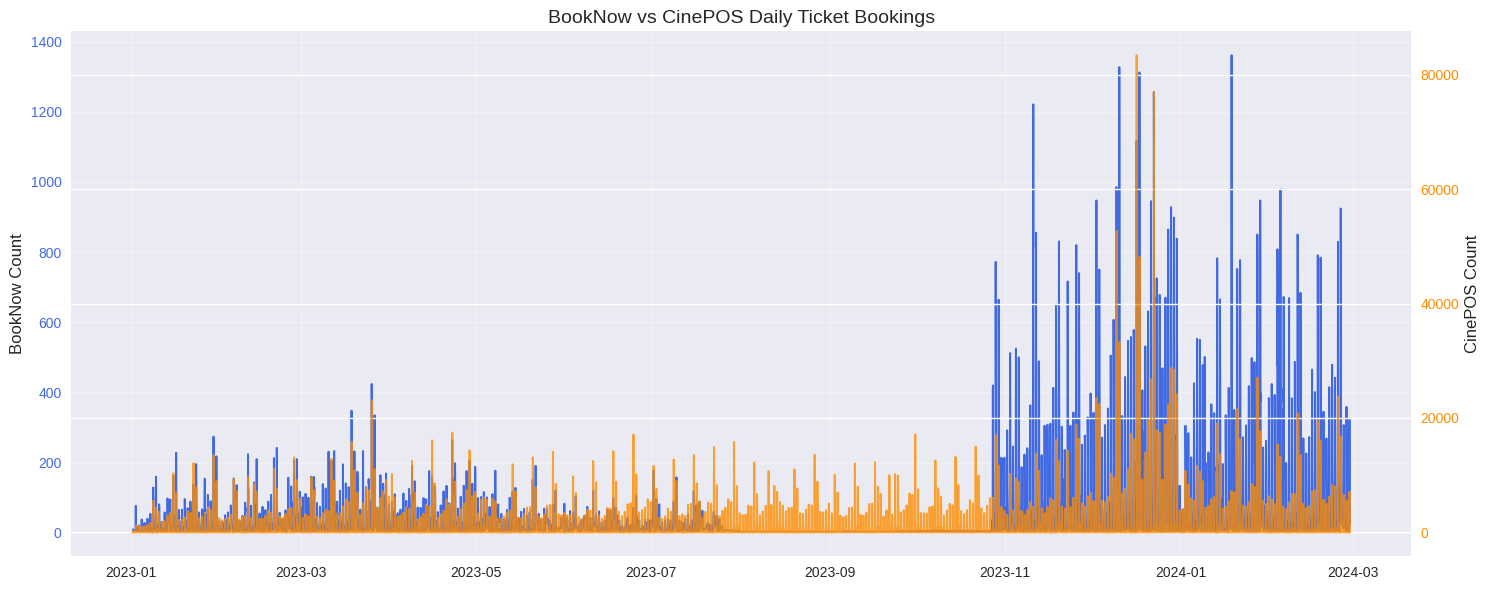


INSIGHTS:
----------------------------------------
CinePOS contributes the max bookings with peak of 83406 bookings on the peak day
Booknow bookings are present, but visually very small compared to CinePOS values
Booknow seems to have lower adoption than CinePOS. Booknow has the max bookings of 1361 only


In [6]:
print("\n" + "Visualizing the booking trends")
print("=" * 80)

# Visualizing the booking trends for BookNow and CinePOS
booknow_booking['show_date'] = pd.to_datetime(booknow_booking['show_datetime'])
cinePOS_booking['show_date'] = pd.to_datetime(cinePOS_booking['show_datetime'])

booknow_trend = booknow_booking.groupby('show_date')['tickets_booked'].sum().reset_index()
cinePOS_trend = cinePOS_booking.groupby('show_date')['tickets_sold'].sum().reset_index()

plt.style.use("seaborn-v0_8")
plt.figure(figsize=(15,6))

fig, ax1 = plt.subplots(figsize=(15,6))

# Booknow trend
ax1.plot(booknow_trend['show_date'], booknow_trend['tickets_booked'], color='royalblue', label='BookNow', linewidth=1.4)
ax1.set_ylabel("BookNow Count", fontsize=12)
ax1.tick_params(axis='y', labelcolor='royalblue')

# Creating second axis for cinepos trend
ax2 = ax1.twinx()
ax2.plot(cinePOS_trend['show_date'], cinePOS_trend['tickets_sold'], color='darkorange', label='CinePOS', alpha=0.8, linewidth=1.4)
ax2.set_ylabel("CinePOS Count", fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title("BookNow vs CinePOS Daily Ticket Bookings", fontsize=14)
ax1.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nINSIGHTS:")
print("-" * 40)
print(f"CinePOS contributes the max bookings with peak of {cinePOS_trend['tickets_sold'].max()} bookings on the peak day")
print(f"Booknow bookings are present, but visually very small compared to CinePOS values")
print(f"Booknow seems to have lower adoption than CinePOS. Booknow has the max bookings of {booknow_trend['tickets_booked'].max()} only")


Time series plot for sample theaters


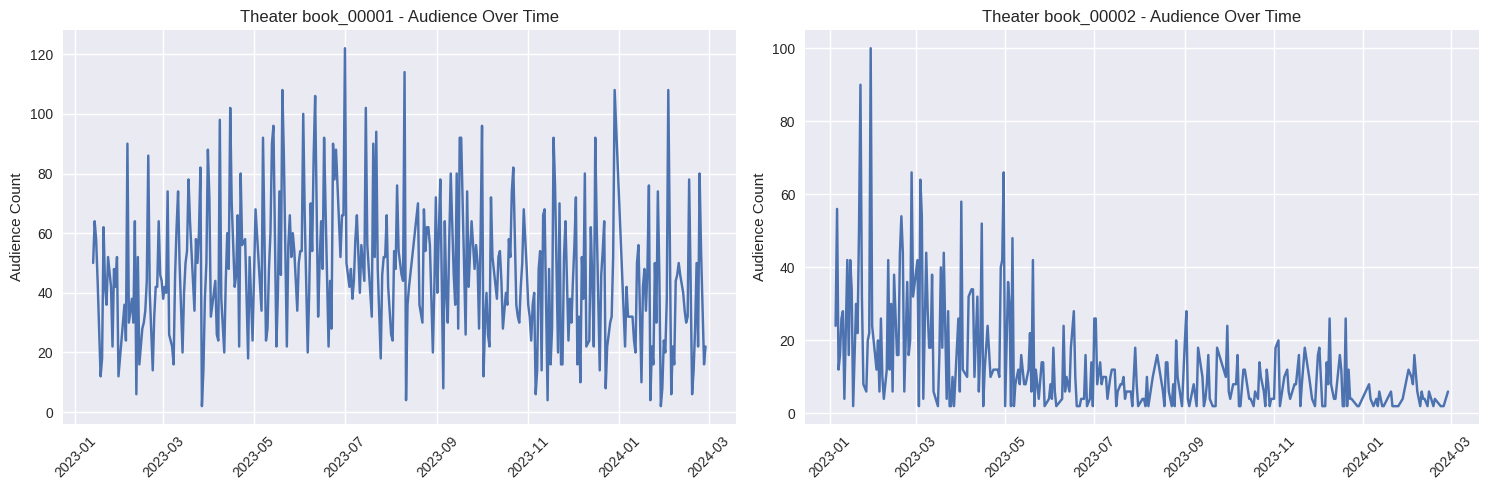


INSIGHTS:
----------------------------------------
Each theater has its own baseline and volatility. So we need to fit per theater models or theater metadata in features
book_00001 is stable over long term but highly volatile.
book_00002 seems to be strong downward trend.
Noise level differs so need to consider rolling and moving averages for modelling


In [7]:
print("\n" + "Time series plot for sample theaters")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))  

sample_theaters = booknow_visits['book_theater_id'].unique()[:2]

for i, theater in enumerate(sample_theaters):
    ax = axes[i]
    theater_data = booknow_visits[booknow_visits['book_theater_id'] == theater]
    theater_data = theater_data.sort_values('show_date')
    ax.plot(theater_data['show_date'], theater_data['audience_count'])
    ax.set_title(f'Theater {theater} - Audience Over Time')
    ax.set_ylabel('Audience Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nINSIGHTS:")
print("-" * 40)
print(f"Each theater has its own baseline and volatility. So we need to fit per theater models or theater metadata in features")
print(f"book_00001 is stable over long term but highly volatile.")
print(f"book_00002 seems to be strong downward trend.")
print(f"Noise level differs so need to consider rolling and moving averages for modelling")


Outlier Analysis


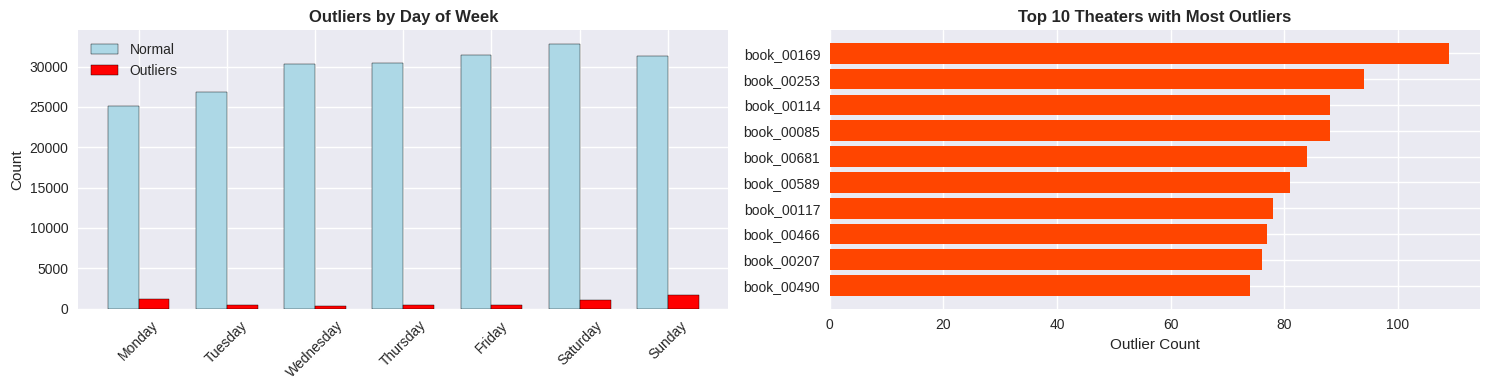


INSIGHTS:
----------------------------------------
Outliers occurs almost every day, but Sundays show the highest
Outliers are not dominating, data is stable. Only 2.61% are outliers
Theaters like book_00169, book_00253, book_00085 show very high outlier counts, maybe due to big space so consider theater area in modelling


In [8]:
print("\n" + "Outlier Analysis")
print("=" * 80)

df = booknow_visits.copy()
df['day_of_week'] = df['show_date'].dt.dayofweek

# Calculate outliers using IQR method
Q1 = df['audience_count'].quantile(0.25)
Q3 = df['audience_count'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR

outliers = df[df['audience_count'] > outlier_threshold].copy()
normal = df[df['audience_count'] <= outlier_threshold].copy()
outlier_percentage = (len(outliers) / len(df)) * 100

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Outliers by day of week
outlier_dow = outliers['day_of_week'].value_counts().sort_index()
normal_dow = normal['day_of_week'].value_counts().sort_index()

x = np.arange(7)

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

axes[0].bar(x - 0.35/2, normal_dow.values, 0.35, label='Normal', color='lightblue', edgecolor='black')
axes[0].bar(x + 0.35/2, outlier_dow.values, 0.35, label='Outliers', color='red', edgecolor='black')

axes[0].set_xticks(x)
axes[0].set_xticklabels(day_names, rotation=45)
axes[0].set_title('Outliers by Day of Week', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].legend()

# Top theaters with outliers
outlier_theaters = outliers['book_theater_id'].value_counts().head(10)

axes[1].barh(outlier_theaters.index, outlier_theaters.values, color='orangered')
axes[1].set_title('Top 10 Theaters with Most Outliers', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Outlier Count')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nINSIGHTS:")
print("-" * 40)
print(f"Outliers occurs almost every day, but Sundays show the highest")
print(f"Outliers are not dominating, data is stable. Only {outlier_percentage:.2f}% are outliers")
print(f"Theaters like book_00169, book_00253, book_00085 show very high outlier counts, maybe due to big space so consider theater area in modelling")

In [9]:
# Extract simple temporal features from booking data for EDA
def extract_temporal_features(df, datetime_col):
    """Extract comprehensive temporal features"""
    df = df.copy()
    df['month'] = df[datetime_col].dt.month
    df['hour'] = df[datetime_col].dt.hour
    
    return df

# Prepare BookNow booking data with temporal features
booknow_booking_temp = extract_temporal_features(booknow_booking, 'show_datetime')
booknow_booking_temp['booking_advance_hours'] = (
    booknow_booking_temp['show_datetime'] - booknow_booking_temp['booking_datetime']
).dt.total_seconds() / 3600

# Prepare CinePOS booking data with temporal features
cinePOS_booking_temp = extract_temporal_features(cinePOS_booking, 'show_datetime')
cinePOS_booking_temp['booking_advance_hours'] = (
    cinePOS_booking_temp['show_datetime'] - cinePOS_booking_temp['booking_datetime']
).dt.total_seconds() / 3600

# Prepare BookNow visits data with temporal features
booknow_visits_temp = extract_temporal_features(booknow_visits, 'show_date')

print("Basic Temporal features extracted for all datasets!")

Basic Temporal features extracted for all datasets!



Monthly booking volumes comparison


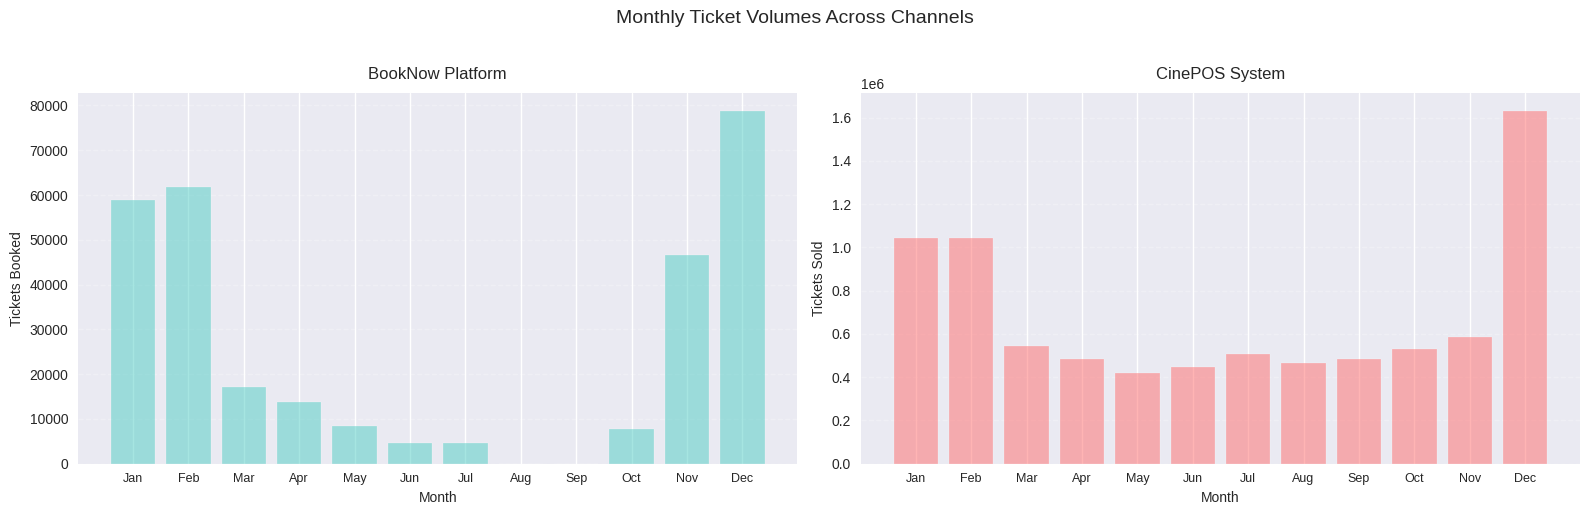


TEMPORAL INSIGHTS:
----------------------------------------
Peak BookNow Month: 12 (78,864 tickets)
Peak CinePOS Month: 12 (1,632,783 tickets)
April to June seems slow


In [10]:
print("\n" + "Monthly booking volumes comparison")
print("=" * 80)

# Monthly booking volumes comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Monthly Ticket Volumes Across Channels', fontsize=14, y=1.02)

# Monthly BookNow volumes
monthly_booknow = booknow_booking_temp.groupby('month')['tickets_booked'].sum()
axes[0].bar(monthly_booknow.index, monthly_booknow.values, color='#4ECDC4', alpha=0.5, edgecolor='white')
axes[0].set_title('BookNow Platform', fontsize=12, pad=10)
axes[0].set_xlabel('Month', fontsize=10)
axes[0].set_ylabel('Tickets Booked', fontsize=10)
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=9)
axes[0].grid(axis='y', alpha=0.25, linestyle='--')

# Monthly CinePOS volumes  
monthly_cinepos = cinePOS_booking_temp.groupby('month')['tickets_sold'].sum()
axes[1].bar(monthly_cinepos.index, monthly_cinepos.values, color='#FF6B6B', alpha=0.5, edgecolor='white')
axes[1].set_title('CinePOS System', fontsize=12, pad=10)
axes[1].set_xlabel('Month', fontsize=10)
axes[1].set_ylabel('Tickets Sold', fontsize=10)
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=9)
axes[1].grid(axis='y', alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

print("\nTEMPORAL INSIGHTS:")
print("-" * 40)
print(f"Peak BookNow Month: {monthly_booknow.idxmax()} ({monthly_booknow.max():,} tickets)")
print(f"Peak CinePOS Month: {monthly_cinepos.idxmax()} ({monthly_cinepos.max():,} tickets)")
print(f"April to June seems slow")


Audience footfall and hourly booking patterns


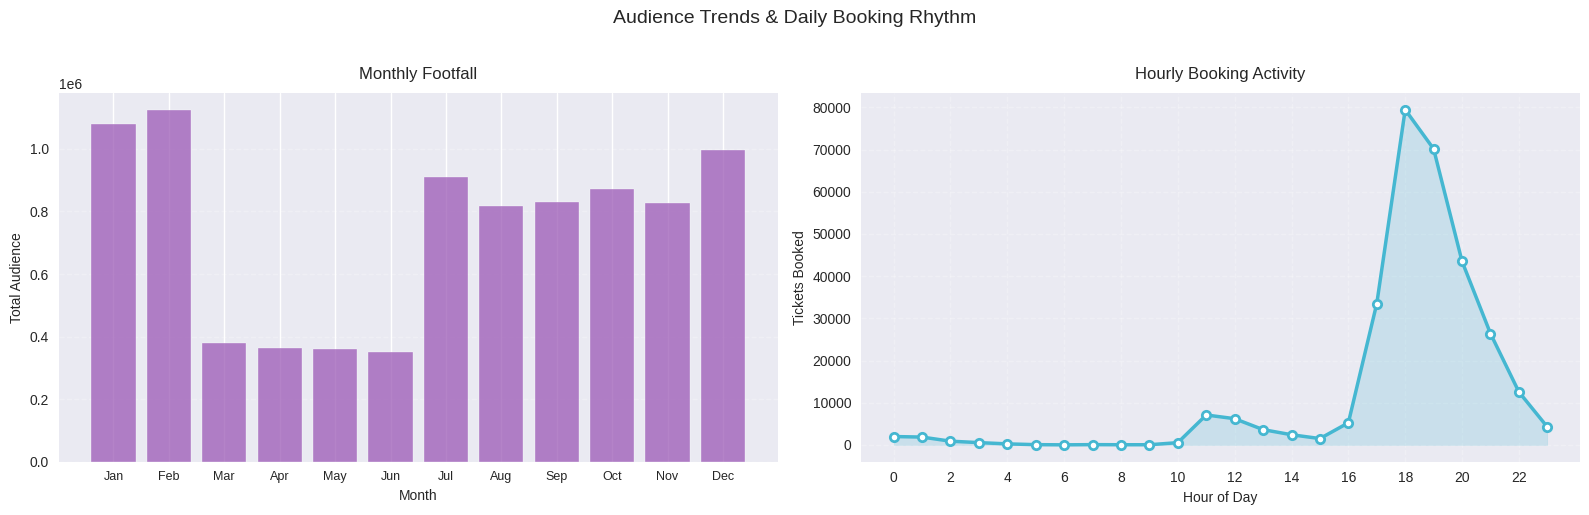


INSIGHTS ON TIMING PATTERNS:
----------------------------------------
Peak Audience Month: 2 (1,122,792 audience)
Low footfall Month: 6 (351,644 audience)
Peak Hour: 18:00 with 79,471 bookings


In [11]:
print("\n" + "Audience footfall and hourly booking patterns")
print("=" * 80)

# Audience footfall and hourly booking patterns  
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Audience Trends & Daily Booking Rhythm', fontsize=14, y=1.02)

# Monthly audience trends
monthly_audience = booknow_visits_temp.groupby('month')['audience_count'].sum()
axes[0].bar(monthly_audience.index, monthly_audience.values, color='#9B59B6', alpha=0.75, edgecolor='white')
axes[0].set_title('Monthly Footfall', fontsize=12, pad=10)
axes[0].set_xlabel('Month', fontsize=10)
axes[0].set_ylabel('Total Audience', fontsize=10)
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=9)
axes[0].grid(axis='y', alpha=0.25, linestyle='--')

# Hourly booking distribution
hourly_booknow = booknow_booking_temp.groupby('hour')['tickets_booked'].sum()
axes[1].plot(hourly_booknow.index, hourly_booknow.values, marker='o', linewidth=2.5, 
             color='#45B7D1', markersize=6, markerfacecolor='white', markeredgewidth=2)
axes[1].fill_between(hourly_booknow.index, hourly_booknow.values, alpha=0.2, color='#45B7D1')
axes[1].set_title('Hourly Booking Activity', fontsize=12, pad=10)
axes[1].set_xlabel('Hour of Day', fontsize=10)
axes[1].set_ylabel('Tickets Booked', fontsize=10)
axes[1].set_xticks(range(0, 24, 2))
axes[1].grid(True, alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

# Insights on timing patterns
print("\nINSIGHTS ON TIMING PATTERNS:")
print("-" * 40)
print(f"Peak Audience Month: {monthly_audience.idxmax()} ({monthly_audience.max():,} audience)")
print(f"Low footfall Month: {monthly_audience.idxmin()} ({monthly_audience.min():,} audience)")
print(f"Peak Hour: {hourly_booknow.idxmax()}:00 with {hourly_booknow.max():,} bookings")


Advance Booking Patterns Across Platforms


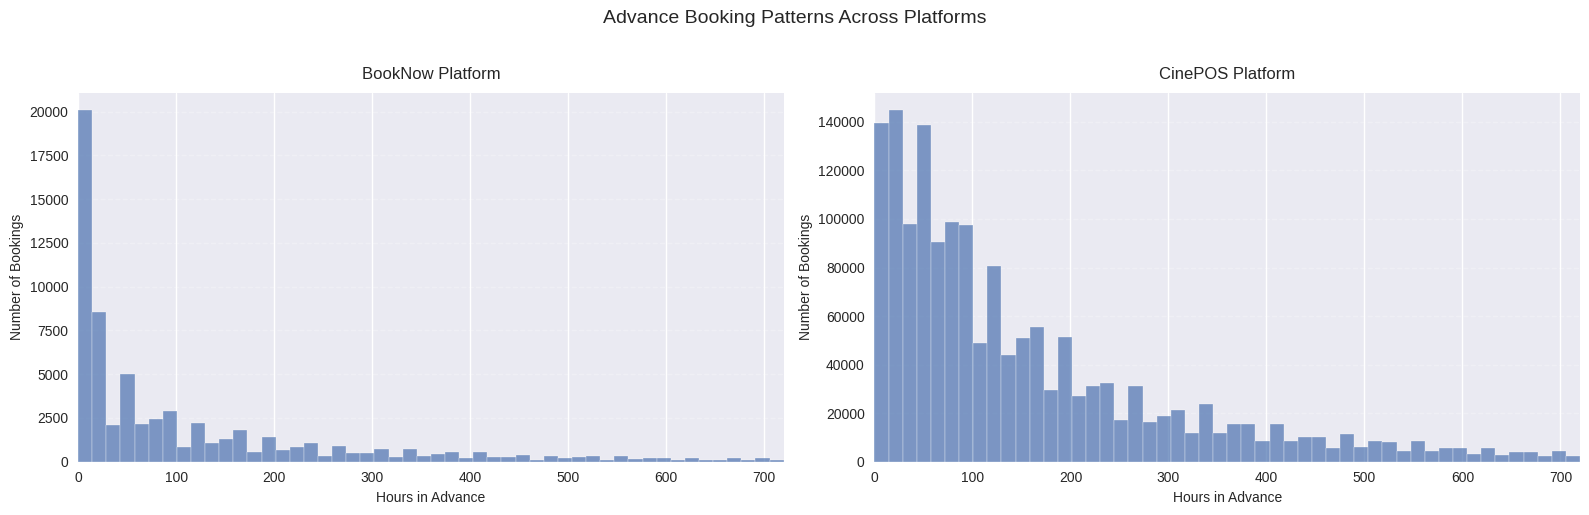


INSIGHTS ON BOOKING TIMINGS:
----------------------------------------
BookNow Advance Booking:
  Mean: 112.9 hours (4 days)
  Median: 47.0 hours (1 days)
  Same-day bookings: 4,995 (7.7%)

CinePOS Advance Booking:
  Mean: 153.8 hours (6 days)
  Median: 99.0 hours (4 days)
  Same-day bookings: 3,821 (0.2%)


In [12]:
print("\n" + "Advance Booking Patterns Across Platforms")
print("=" * 80)

# Advance booking patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Advance Booking Patterns Across Platforms', fontsize=14, y=1.02)

# BookNow advance booking distribution
advance_hours_booknow = booknow_booking_temp['booking_advance_hours']
advance_hours_booknow_clean = advance_hours_booknow[(advance_hours_booknow >= 0) & (advance_hours_booknow <= 720)]

axes[0].hist(advance_hours_booknow_clean, bins=50, alpha=0.7, edgecolor='white')
axes[0].set_title('BookNow Platform', fontsize=12, pad=10)
axes[0].set_xlabel('Hours in Advance', fontsize=10)
axes[0].set_ylabel('Number of Bookings', fontsize=10)
axes[0].set_xlim(0, 720)
axes[0].grid(axis='y', alpha=0.25, linestyle='--')

# CinePOS advance booking distribution
advance_hours_cinepos = cinePOS_booking_temp['booking_advance_hours']
advance_hours_cinepos_clean = advance_hours_cinepos[(advance_hours_cinepos >= 0) & (advance_hours_cinepos <= 720)]

axes[1].hist(advance_hours_cinepos_clean, bins=50, alpha=0.7, edgecolor='white')
axes[1].set_title('CinePOS Platform', fontsize=12, pad=10)
axes[1].set_xlabel('Hours in Advance', fontsize=10)
axes[1].set_ylabel('Number of Bookings', fontsize=10)
axes[1].set_xlim(0, 720)
axes[1].grid(axis='y', alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

# Observations on booking timing behavior
print("\nINSIGHTS ON BOOKING TIMINGS:")
print("-" * 40)

print("BookNow Advance Booking:")
print(f"  Mean: {advance_hours_booknow_clean.mean():.1f} hours ({int(advance_hours_booknow_clean.mean()/24)} days)")
print(f"  Median: {advance_hours_booknow_clean.median():.1f} hours ({int(advance_hours_booknow_clean.median()/24)} days)")
print(f"  Same-day bookings: {(advance_hours_booknow_clean < 1).sum():,} ({(advance_hours_booknow_clean < 1).mean()*100:.1f}%)")

print("\nCinePOS Advance Booking:")
print(f"  Mean: {advance_hours_cinepos_clean.mean():.1f} hours ({int(advance_hours_cinepos_clean.mean()/24)} days)")
print(f"  Median: {advance_hours_cinepos_clean.median():.1f} hours ({int(advance_hours_cinepos_clean.median()/24)} days)")
print(f"  Same-day bookings: {(advance_hours_cinepos_clean < 1).sum():,} ({(advance_hours_cinepos_clean < 1).mean()*100:.1f}%)")


Booking Sizes


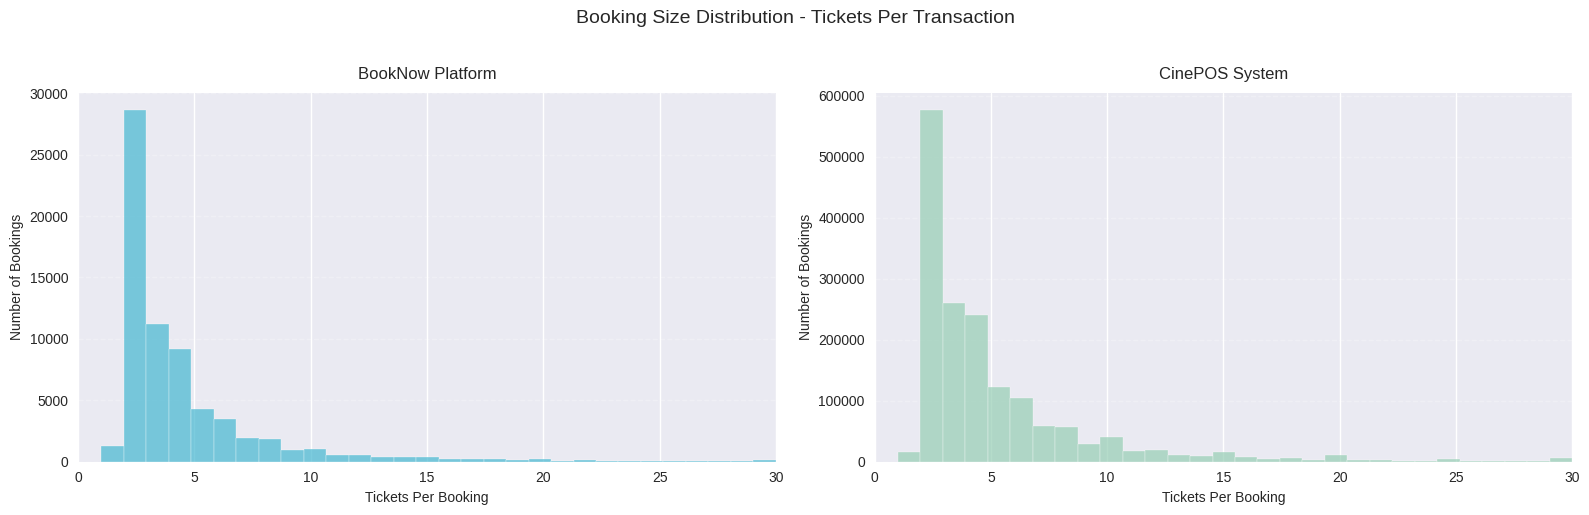


BOOKING BEHAVIOR STATISTICS:
----------------------------------------
BookNow average: 4.43 tickets per booking
BookNow median: 3 tickets (typical transaction)

CinePOS average: 4.99 tickets per booking
CinePOS median: 3 tickets

Both platforms heavily skewed toward small bookings
Max booking sizes: BookNow 100, CinePOS 100 tickets


In [13]:
print("\n" + "Booking Sizes")
print("=" * 80)

# Typical booking sizes (tickets per transaction)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Booking Size Distribution - Tickets Per Transaction', fontsize=14, y=1.02)

# BookNow booking sizes
booking_size_booknow = booknow_booking_temp['tickets_booked']
booking_size_booknow_plot = booking_size_booknow[booking_size_booknow <= 30]  # Filter outliers for better viz

axes[0].hist(booking_size_booknow_plot, bins=30, color='#45B7D1', alpha=0.7, edgecolor='white')
axes[0].set_title('BookNow Platform', fontsize=12, pad=10)
axes[0].set_xlabel('Tickets Per Booking', fontsize=10)
axes[0].set_ylabel('Number of Bookings', fontsize=10)
axes[0].set_xlim(0, 30)
axes[0].grid(axis='y', alpha=0.25, linestyle='--')

# CinePOS booking sizes
booking_size_cinepos = cinePOS_booking_temp['tickets_sold']
booking_size_cinepos_plot = booking_size_cinepos[booking_size_cinepos <= 30]

axes[1].hist(booking_size_cinepos_plot, bins=30, color='#96CEB4', alpha=0.7, edgecolor='white')
axes[1].set_title('CinePOS System', fontsize=12, pad=10)
axes[1].set_xlabel('Tickets Per Booking', fontsize=10)
axes[1].set_ylabel('Number of Bookings', fontsize=10)
axes[1].set_xlim(0, 30)
axes[1].grid(axis='y', alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

# Booking size observations
print("\nBOOKING BEHAVIOR STATISTICS:")
print("-" * 40)

print(f"BookNow average: {booking_size_booknow.mean():.2f} tickets per booking")
print(f"BookNow median: {booking_size_booknow.median():.0f} tickets (typical transaction)")

print(f"\nCinePOS average: {booking_size_cinepos.mean():.2f} tickets per booking")
print(f"CinePOS median: {booking_size_cinepos.median():.0f} tickets")

print(f"\nBoth platforms heavily skewed toward small bookings")
print(f"Max booking sizes: BookNow {booking_size_booknow.max():.0f}, CinePOS {booking_size_cinepos.max():.0f} tickets")

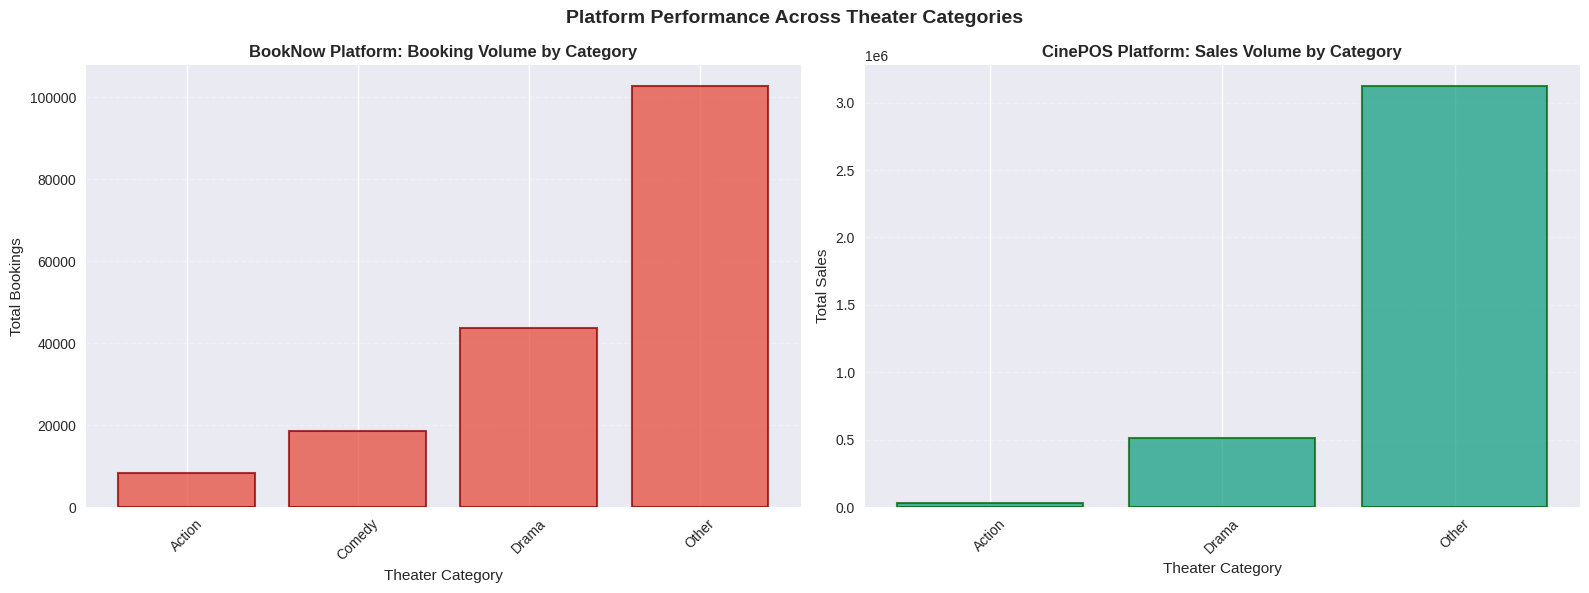


PLATFORM PERFORMANCE BY THEATER CATEGORY

BookNow Platform:
  • Action: 8,336 total | 4.3 avg | 1,933 transactions
  • Comedy: 18,530 total | 5.0 avg | 3,728 transactions
  • Drama: 43,767 total | 4.5 avg | 9,828 transactions
  • Other: 102,704 total | 4.8 avg | 21,410 transactions

CinePOS Platform:
  • Action: 31,264 total | 4.4 avg | 7,099 transactions
  • Drama: 513,976 total | 5.2 avg | 98,696 transactions
  • Other: 3,120,764 total | 5.3 avg | 593,876 transactions


In [14]:
# Theater Performance Analysis

# Merge booking data with theater information for performance analysis
def merge_booking_theater_data(booking_df, theater_df, booking_col, theater_id_col):
    """Merge booking data with theater information"""
    merged = booking_df.merge(
        theater_df, 
        left_on=booking_df.columns[0],  
        right_on=theater_id_col,
        how='left'
    )
    return merged

# Merge BookNow data
booknow_performance = merge_booking_theater_data(
    booknow_booking_temp, 
    booknow_theaters_cleaned, 
    'tickets_booked',
    booknow_theaters_cleaned.columns[0]
)

# Merge CinePOS data  
cinePOS_performance = merge_booking_theater_data(
    cinePOS_booking_temp,
    cinePOS_theaters_cleaned,
    'tickets_sold', 
    cinePOS_theaters_cleaned.columns[0]
)

# Merge visits data with theater info
visits_performance = booknow_visits_temp.merge(
    booknow_theaters_cleaned,
    left_on='book_theater_id',
    right_on=booknow_theaters_cleaned.columns[0],
    how='left'
)
# Platform Performance Comparison by Theater Category


bn_category_metrics = booknow_performance.groupby('theater_type')['tickets_booked'].agg(['sum', 'mean', 'count'])
cp_category_metrics = cinePOS_performance.groupby('theater_type')['tickets_sold'].agg(['sum', 'mean', 'count'])

# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Platform Performance Across Theater Categories', fontsize=14, fontweight='bold')

# BookNow platform 
ax1.bar(bn_category_metrics.index, bn_category_metrics['sum'], 
        color='#E74C3C', alpha=0.75, edgecolor='darkred', linewidth=1.5)
ax1.set_title('BookNow Platform: Booking Volume by Category', fontweight='bold', fontsize=12)
ax1.set_xlabel('Theater Category', fontsize=11)
ax1.set_ylabel('Total Bookings', fontsize=11)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.25, linestyle='--')

# CinePOS platform 
ax2.bar(cp_category_metrics.index, cp_category_metrics['sum'],
        color='#16A085', alpha=0.75, edgecolor='darkgreen', linewidth=1.5)
ax2.set_title('CinePOS Platform: Sales Volume by Category', fontweight='bold', fontsize=12)
ax2.set_xlabel('Theater Category', fontsize=11)
ax2.set_ylabel('Total Sales', fontsize=11)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

print("\nPLATFORM PERFORMANCE BY THEATER CATEGORY")

print("\nBookNow Platform:")
for category in bn_category_metrics.index:
    volume = bn_category_metrics.loc[category, 'sum']
    average = bn_category_metrics.loc[category, 'mean']
    transactions = bn_category_metrics.loc[category, 'count']
    print(f"  • {category}: {volume:,} total | {average:.1f} avg | {transactions:,} transactions")

print("\nCinePOS Platform:")
for category in cp_category_metrics.index:
    volume = cp_category_metrics.loc[category, 'sum']
    average = cp_category_metrics.loc[category, 'mean']
    transactions = cp_category_metrics.loc[category, 'count']
    print(f"  • {category}: {volume:,} total | {average:.1f} avg | {transactions:,} transactions")

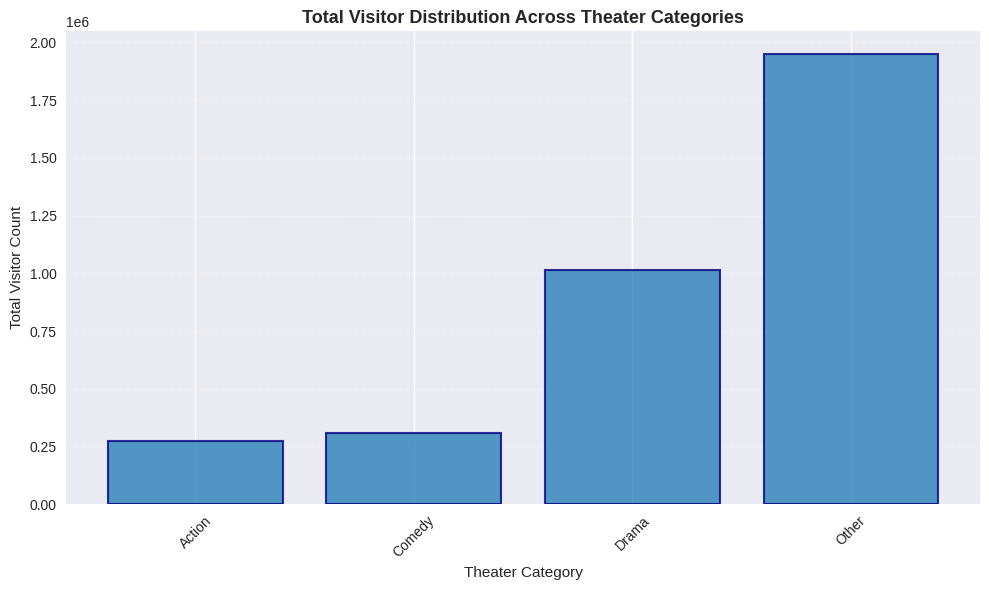


VISITOR METRICS BY THEATER CATEGORY
  • Action: 271,928 total visitors | 47.2 average per visit
  • Comedy: 309,010 total visitors | 47.0 average per visit
  • Drama: 1,012,292 total visitors | 43.6 average per visit
  • Other: 1,950,558 total visitors | 43.7 average per visit


In [15]:
# Visitor Analysis by Theater Category


category_visitor_stats = visits_performance.groupby('theater_type')['audience_count'].agg(['sum', 'mean'])

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(category_visitor_stats.index, category_visitor_stats['sum'],
       color='#2980B9', alpha=0.8, edgecolor='navy', linewidth=1.5)
ax.set_title('Total Visitor Distribution Across Theater Categories', 
             fontweight='bold', fontsize=13)
ax.set_xlabel('Theater Category', fontsize=11)
ax.set_ylabel('Total Visitor Count', fontsize=11)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

print("\nVISITOR METRICS BY THEATER CATEGORY")

for category in category_visitor_stats.index:
    total_visitors = category_visitor_stats.loc[category, 'sum']
    avg_visitors = category_visitor_stats.loc[category, 'mean']
    print(f"  • {category}: {total_visitors:,} total visitors | {avg_visitors:.1f} average per visit")

### MERGING DATASETS

In [16]:
print("\n" + "MERGING BOOKINGS INFORMATION")
print("="*80)

def add_bookings_info(master_df, booknow_booking_cleaned, cinepos_booking_cleaned, mapping):
    """
    Merge booking information to master dataset.
    """
    # Prepare booknow booking data
    booknow_booking_cleaned["show_date"] = booknow_booking_cleaned["show_datetime"].dt.floor("D")
    
    agg_booknow = booknow_booking_cleaned.groupby(["book_theater_id","show_date"]).agg(
        tickets_booked=("tickets_booked","sum"),
    ).reset_index()
    
    master_df = master_df.merge(agg_booknow, on=["book_theater_id","show_date"], how="left")
    
    # Prepare cinepos booking data
    cinepos_booking_cleaned = cinepos_booking_cleaned.merge(mapping, on="cine_theater_id", how="left").dropna(subset=["book_theater_id"])
    
    cinepos_booking_cleaned["show_date"] = cinepos_booking_cleaned["show_datetime"].dt.floor("D")
    
    agg_cine = cinepos_booking_cleaned.groupby(["book_theater_id","show_date"]).agg(
        tickets_sold=("tickets_sold","sum"),
    ).reset_index()
    
    master_df = master_df.merge(agg_cine, on=["book_theater_id","show_date"], how="left")
    
    return master_df

master_df = booknow_visits_cleaned.copy()
master_df = add_bookings_info(master_df, booknow_booking_cleaned, cinePOS_booking_cleaned, movie_theater_id_relation)

print("\nMissing values in booking columns:")
print(master_df[['tickets_booked', 'tickets_sold']].isnull().sum())

missing_pct_booked = (master_df['tickets_booked'].isnull().sum() / len(master_df)) * 100
missing_pct_sold = (master_df['tickets_sold'].isnull().sum() / len(master_df)) * 100

print(f"\ntickets_booked missing: {missing_pct_booked:.1f}%")
print(f"tickets_sold missing: {missing_pct_sold:.1f}%")

master_df.drop(columns=['tickets_booked', 'tickets_sold'], inplace=True)

# After merging more than 90% of tickets booked and tickets sold cols were missing. So removed those cols.


MERGING BOOKINGS INFORMATION

Missing values in booking columns:
tickets_booked    192995
tickets_sold      202886
dtype: int64

tickets_booked missing: 90.2%
tickets_sold missing: 94.8%


In [17]:
print("\n" + "MERGING THEATER METADATA")
print("="*80)

def add_theater_info(booknow_visits_cleaned, booknow_theaters_cleaned):
    """
    Merge theater metadata into the visits dataset.
    """
    master_df = booknow_visits_cleaned.copy()
    master_df = pd.merge(master_df, booknow_theaters_cleaned, on='book_theater_id', how="left")

    master_df['is_theater_info_missing'] = master_df['theater_type'].isnull().astype(int)
    master_df['theater_type'] = master_df['theater_type'].fillna('Unknown')
    master_df['theater_area'] = master_df['theater_area'].fillna('Unknown')
    
    return master_df

master_df = add_theater_info(booknow_visits_cleaned, booknow_theaters_cleaned)

missing_pct = (master_df['is_theater_info_missing'].sum() / len(master_df)) * 100
print(f"\nTheater info missing: {missing_pct:.1f}% of records")

def check_cinepos_theaters(master_df, cinePOS_theaters_cleaned, mapping):

    # Merge cinepos theaters with mapping
    cinePOS_theaters_cleaned = cinePOS_theaters_cleaned.merge(
        mapping, on="cine_theater_id", how="left"
    )

    cinepos_with_book_id = cinePOS_theaters_cleaned.dropna(subset=["book_theater_id"])
    print(f"\nCinepos theaters with valid book_theater_id: {len(cinepos_with_book_id)}")

    missing_theaters = (
        master_df.loc[master_df['is_theater_info_missing'] == 1, 'book_theater_id']
        .dropna().unique().tolist()
    )

    cinepos_ids = cinepos_with_book_id['book_theater_id'].unique().tolist()

    present_in_cinepos = [t for t in missing_theaters if t in cinepos_ids]
    not_in_cinepos = [t for t in missing_theaters if t not in cinepos_ids]

    print(f"\nMissing theaters in master: {len(missing_theaters)}")
    print(f"Found in cinepos: {len(present_in_cinepos)} ({len(present_in_cinepos)/len(missing_theaters)*100:.1f}%)")
    print(f"NOT in cinepos: {len(not_in_cinepos)} ({len(not_in_cinepos)/len(missing_theaters)*100:.1f}%)")

    return 

check_cinepos_theaters(master_df, cinePOS_theaters_cleaned, movie_theater_id_relation)

# Only 22 out of 513 theatres are present in cinepos. So not using it for imputation

print(f'\nDatasets merged successfully.')


MERGING THEATER METADATA

Theater info missing: 62.6% of records

Cinepos theaters with valid book_theater_id: 63

Missing theaters in master: 513
Found in cinepos: 22 (4.3%)
NOT in cinepos: 491 (95.7%)

Datasets merged successfully.


### TRAIN-VALIDATION SPLIT

In [18]:
print("\n" + "TRAIN-VALIDATION SPLIT")
print("="*80)

master_df = booknow_visits_cleaned.copy()
cutoff_date = master_df['show_date'].max() - pd.DateOffset(months=2)
train_df = master_df[master_df['show_date'] <= cutoff_date].copy()
val_df = master_df[master_df['show_date'] > cutoff_date].copy()

print(f"Train: {train_df['show_date'].min()} to {train_df['show_date'].max()} ({len(train_df):,} rows)")
print(f"Val:   {val_df['show_date'].min()} to {val_df['show_date'].max()} ({len(val_df):,} rows)")


TRAIN-VALIDATION SPLIT
Train: 2023-01-01 00:00:00 to 2023-12-28 00:00:00 (172,961 rows)
Val:   2023-12-29 00:00:00 to 2024-02-28 00:00:00 (41,075 rows)


### DATA PREPROCESSING

In [19]:
def add_calendar_features(df):
    """Basic temporal features"""
    f = df.copy()
    f['show_date'] = pd.to_datetime(f['show_date'])
    
    f['day_of_week'] = f['show_date'].dt.dayofweek
    f['day_of_month'] = f['show_date'].dt.day
    f['month'] = f['show_date'].dt.month
    f['quarter'] = f['show_date'].dt.quarter
    f['week_of_year'] = f['show_date'].dt.isocalendar().week.astype(int)
    
    f['is_weekend'] = f['day_of_week'].isin([5, 6]).astype(int)
    f['is_friday'] = (f['day_of_week'] == 4).astype(int)
    
    f['dow_sin'] = np.sin(2 * np.pi * f['day_of_week'] / 7)
    f['dow_cos'] = np.cos(2 * np.pi * f['day_of_week'] / 7)
    f['month_sin'] = np.sin(2 * np.pi * f['month'] / 12)
    f['month_cos'] = np.cos(2 * np.pi * f['month'] / 12)
    
    return f


def add_robust_lag_features(df):
    """Lag features"""
    f = df.copy()
    f = f.sort_values(['book_theater_id', 'show_date'])
    
    f['lag_7'] = f.groupby('book_theater_id')['audience_count'].shift(7)
    f['lag_14'] = f.groupby('book_theater_id')['audience_count'].shift(14)
    f['lag_21'] = f.groupby('book_theater_id')['audience_count'].shift(21)
    f['lag_28'] = f.groupby('book_theater_id')['audience_count'].shift(28)
    
    f['same_dow_lag_1w'] = f.groupby('book_theater_id')['audience_count'].shift(7)
    f['same_dow_lag_2w'] = f.groupby('book_theater_id')['audience_count'].shift(14)
    f['same_dow_lag_3w'] = f.groupby('book_theater_id')['audience_count'].shift(21)
    f['same_dow_lag_4w'] = f.groupby('book_theater_id')['audience_count'].shift(28)
    f['same_dow_mean_4w'] = f[['same_dow_lag_1w', 'same_dow_lag_2w',
                                'same_dow_lag_3w', 'same_dow_lag_4w']].mean(axis=1)
    
    f['rolling_mean_7'] = f.groupby('book_theater_id')['audience_count'].transform(
        lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
    )
    f['rolling_mean_14'] = f.groupby('book_theater_id')['audience_count'].transform(
        lambda x: x.shift(1).rolling(window=14, min_periods=1).mean()
    )
    f['rolling_mean_28'] = f.groupby('book_theater_id')['audience_count'].transform(
        lambda x: x.shift(1).rolling(window=28, min_periods=1).mean()
    )
    
    f = f.dropna(subset=['lag_28', 'same_dow_lag_4w', 'rolling_mean_28'])
    return f

In [20]:
print("\n" + "BUILDING TRAINING FEATURES")
print("="*80)

train_df = train_df.copy()
train_df = add_calendar_features(train_df)

label_encoder = LabelEncoder()
train_df['theater_id_encoded'] = label_encoder.fit_transform(train_df['book_theater_id'])

train_df = add_robust_lag_features(train_df)

FEATURES = [
    'theater_id_encoded',
    'day_of_week', 'day_of_month', 'month', 'quarter', 'week_of_year',
    'is_weekend', 'is_friday',
    'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
    'lag_7', 'lag_14', 'lag_21', 'lag_28',
    'same_dow_lag_1w', 'same_dow_lag_2w', 'same_dow_lag_3w', 'same_dow_lag_4w',
    'same_dow_mean_4w',
    'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28'
]

print(f"Features: {len(FEATURES)}")

X_train = train_df[FEATURES]
y_train = train_df['audience_count']

# Prepare validation setup
val_dates = sorted(val_df['show_date'].unique())
train_theaters = set(train_df['book_theater_id'].unique())
val_theaters = set(val_df['book_theater_id'].unique())
seen_val_theaters = list(val_theaters.intersection(train_theaters))

print(f"Training samples: {len(X_train):,}")
print(f"Validation theaters: {len(seen_val_theaters)}")


BUILDING TRAINING FEATURES
Features: 24
Training samples: 150,132
Validation theaters: 806


### MODEL EVALUATION

In [21]:
print("\n" + "TRAINING LINEAR REGRESSION")
print("="*80)

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
print("✓ Linear Regression trained")


TRAINING LINEAR REGRESSION
✓ Linear Regression trained


In [22]:
def multi_step_forecast(train_data, forecast_dates, forecast_theaters,
                       label_encoder, scaler, model, features):
    """Multi-step forecasting maintaining continuity from training data"""
    forecast_rows = []
    print(f"Forecasting {len(forecast_theaters) * len(forecast_dates):,} predictions")
    start_time = time.time()
    
    for i, theater_id in enumerate(forecast_theaters):
        theater_id_enc = label_encoder.transform([theater_id])[0]
        history = train_data[train_data['book_theater_id'] == theater_id].sort_values('show_date').copy()
        
        for next_date in forecast_dates:
            row = pd.DataFrame({'book_theater_id': [theater_id], 'show_date': [next_date]})
            row = add_calendar_features(row)
            row['theater_id_encoded'] = theater_id_enc
            
            last_28 = history.tail(28)['audience_count']
            theater_mean = history['audience_count'].mean() if len(history) > 0 else 0
            
            row['lag_7'] = last_28.iloc[-7] if len(last_28) >= 7 else theater_mean
            row['lag_14'] = last_28.iloc[-14] if len(last_28) >= 14 else theater_mean
            row['lag_21'] = last_28.iloc[-21] if len(last_28) >= 21 else theater_mean
            row['lag_28'] = last_28.iloc[-28] if len(last_28) >= 28 else theater_mean
            
            row['same_dow_lag_1w'] = last_28.iloc[-7] if len(last_28) >= 7 else theater_mean
            row['same_dow_lag_2w'] = last_28.iloc[-14] if len(last_28) >= 14 else theater_mean
            row['same_dow_lag_3w'] = last_28.iloc[-21] if len(last_28) >= 21 else theater_mean
            row['same_dow_lag_4w'] = last_28.iloc[-28] if len(last_28) >= 28 else theater_mean
            
            row['same_dow_mean_4w'] = np.mean([
                row['same_dow_lag_1w'].iloc[0], row['same_dow_lag_2w'].iloc[0],
                row['same_dow_lag_3w'].iloc[0], row['same_dow_lag_4w'].iloc[0]
            ])
            
            row['rolling_mean_7'] = last_28.tail(7).mean() if len(last_28) >= 1 else theater_mean
            row['rolling_mean_14'] = last_28.tail(14).mean() if len(last_28) >= 1 else theater_mean
            row['rolling_mean_28'] = last_28.mean() if len(last_28) >= 1 else theater_mean
            
            row = row.fillna(theater_mean)
            
            # Model prediction
            row_scaled = pd.DataFrame(scaler.transform(row[features]), columns=features)
            model_pred = model.predict(row_scaled)[0]
            
            row['audience_count'] = max(model_pred, 0)
            history = pd.concat([history, row[['show_date', 'audience_count']]], ignore_index=True)
            forecast_rows.append(row)
    
    elapsed = time.time() - start_time
    print(f"✓ Complete: {elapsed:.1f}s ({elapsed/60:.1f} min)")
    
    return pd.concat(forecast_rows, ignore_index=True)

In [23]:
print("\n" + "VALIDATING LINEAR REGRESSION")
print("="*80)

results = []

scaler_lr = lr_pipeline.named_steps['scaler']
model_lr = lr_pipeline.named_steps['model']

val_forecast_lr = multi_step_forecast(
    train_data=train_df,
    forecast_dates=val_dates,
    forecast_theaters=seen_val_theaters,
    label_encoder=label_encoder,
    scaler=scaler_lr,
    model=model_lr,
    features=FEATURES,
)

val_actual = val_df[['book_theater_id', 'show_date', 'audience_count']].copy()
comparison_lr = val_actual.merge(
    val_forecast_lr[['book_theater_id', 'show_date', 'audience_count']],
    on=['book_theater_id', 'show_date'],
    suffixes=('_actual', '_pred')
)

r2_lr = r2_score(comparison_lr['audience_count_actual'], comparison_lr['audience_count_pred'])
mae_lr = mean_absolute_error(comparison_lr['audience_count_actual'], comparison_lr['audience_count_pred'])

results.append({
    'Model': 'Linear Regression',
    'Val_R2': r2_lr,
    'Val_MAE': mae_lr
})

print(f"\nLINEAR REGRESSION RESULTS:")
print(f"  R²: {r2_lr:.5f}")
print(f"  MAE: {mae_lr:.2f}")


VALIDATING LINEAR REGRESSION
Forecasting 49,972 predictions
✓ Complete: 615.6s (10.3 min)

LINEAR REGRESSION RESULTS:
  R²: 0.39639
  MAE: 17.23


In [24]:
print("\n" + "TRAINING K-NEAREST NEIGHBORS")
print("="*80)

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor(
        n_neighbors=5,
        weights='distance',
        metric='euclidean'
    ))
])

knn_pipeline.fit(X_train, y_train)

print("✓ KNN trained")


TRAINING K-NEAREST NEIGHBORS
✓ KNN trained


In [25]:
print("\n" + "VALIDATING K-NEAREST NEIGHBORS")
print("="*80)

scaler_knn = knn_pipeline.named_steps['scaler']
model_knn = knn_pipeline.named_steps['model']

val_forecast_knn = multi_step_forecast(
    train_data=train_df,
    forecast_dates=val_dates,
    forecast_theaters=seen_val_theaters,
    label_encoder=label_encoder,
    scaler=scaler_knn,
    model=model_knn,
    features=FEATURES
)

comparison_knn = val_actual.merge(
    val_forecast_knn[['book_theater_id', 'show_date', 'audience_count']],
    on=['book_theater_id', 'show_date'],
    suffixes=('_actual', '_pred')
)

r2_knn = r2_score(comparison_knn['audience_count_actual'], comparison_knn['audience_count_pred'])
mae_knn = mean_absolute_error(comparison_knn['audience_count_actual'], comparison_knn['audience_count_pred'])

results.append({
    'Model': 'KNN',
    'Val_R2': r2_knn,
    'Val_MAE': mae_knn
})

print(f"\nK-NEAREST NEIGHBORS RESULTS:")
print(f"  R²: {r2_knn:.5f}")
print(f"  MAE: {mae_knn:.2f}")


VALIDATING K-NEAREST NEIGHBORS
Forecasting 49,972 predictions
✓ Complete: 936.5s (15.6 min)

K-NEAREST NEIGHBORS RESULTS:
  R²: 0.28192
  MAE: 19.71


In [26]:
print("\n" + "TRAINING RANDOM FOREST")
print("="*80)

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)

print("✓ Random Forest trained")


TRAINING RANDOM FOREST
✓ Random Forest trained


In [27]:
print("\n" + "VALIDATING RANDOM FOREST")
print("="*80)

scaler_rf = rf_pipeline.named_steps['scaler']
model_rf = rf_pipeline.named_steps['model']

val_forecast_rf = multi_step_forecast(
    train_data=train_df,
    forecast_dates=val_dates,
    forecast_theaters=seen_val_theaters,
    label_encoder=label_encoder,
    scaler=scaler_rf,
    model=model_rf,
    features=FEATURES
)

comparison_rf = val_actual.merge(
    val_forecast_rf[['book_theater_id', 'show_date', 'audience_count']],
    on=['book_theater_id', 'show_date'],
    suffixes=('_actual', '_pred')
)

r2_rf = r2_score(comparison_rf['audience_count_actual'], comparison_rf['audience_count_pred'])
mae_rf = mean_absolute_error(comparison_rf['audience_count_actual'], comparison_rf['audience_count_pred'])

results.append({
    'Model': 'Random Forest',
    'Val_R2': r2_rf,
    'Val_MAE': mae_rf
})

print(f"\nRANDOM FOREST RESULTS:")
print(f"  R²: {r2_rf:.5f}")
print(f"  MAE: {mae_rf:.2f}")


VALIDATING RANDOM FOREST
Forecasting 49,972 predictions
✓ Complete: 1700.8s (28.3 min)

RANDOM FOREST RESULTS:
  R²: 0.30790
  MAE: 19.18


In [28]:
print("\n" + "TRAINING LIGHTGBM")
print("="*80)

lgbm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        num_leaves=31,
        random_state=42,
        verbosity=-1
    ))
])

lgbm_pipeline.fit(X_train, y_train)

print("✓ LightGBM trained")


TRAINING LIGHTGBM
✓ LightGBM trained


In [29]:
print("\n" + "VALIDATING LIGHTGBM")
print("="*80)

scaler_lgbm = lgbm_pipeline.named_steps['scaler']
model_lgbm = lgbm_pipeline.named_steps['model']

val_forecast_lgbm = multi_step_forecast(
    train_data=train_df,
    forecast_dates=val_dates,
    forecast_theaters=seen_val_theaters,
    label_encoder=label_encoder,
    scaler=scaler_lgbm,
    model=model_lgbm,
    features=FEATURES
)

comparison_lgbm = val_actual.merge(
    val_forecast_lgbm[['book_theater_id', 'show_date', 'audience_count']],
    on=['book_theater_id', 'show_date'],
    suffixes=('_actual', '_pred')
)

r2_lgbm = r2_score(comparison_lgbm['audience_count_actual'], comparison_lgbm['audience_count_pred'])
mae_lgbm = mean_absolute_error(comparison_lgbm['audience_count_actual'], comparison_lgbm['audience_count_pred'])

results.append({
    'Model': 'LightGBM',
    'Val_R2': r2_lgbm,
    'Val_MAE': mae_lgbm
})

print(f"\nLIGHTGBM RESULTS:")
print(f"  R²: {r2_lgbm:.5f}")
print(f"  MAE: {mae_lgbm:.2f}")


VALIDATING LIGHTGBM
Forecasting 49,972 predictions
✓ Complete: 641.9s (10.7 min)

LIGHTGBM RESULTS:
  R²: 0.35383
  MAE: 18.43


In [30]:
print("\n" + "TRAINING XGBOOST")
print("="*80)

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(
        n_estimators=250,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ))
])

xgb_pipeline.fit(X_train, y_train)

print("✓ XGBoost trained")


TRAINING XGBOOST
✓ XGBoost trained


In [31]:
print("\n" + "VALIDATING XGBOOST")
print("="*80)

scaler_xgb_base = xgb_pipeline.named_steps['scaler']
model_xgb_base = xgb_pipeline.named_steps['model']

val_forecast_xgb_base = multi_step_forecast(
    train_data=train_df,
    forecast_dates=val_dates,
    forecast_theaters=seen_val_theaters,
    label_encoder=label_encoder,
    scaler=scaler_xgb_base,
    model=model_xgb_base,
    features=FEATURES
)

comparison_xgb_base = val_actual.merge(
    val_forecast_xgb_base[['book_theater_id', 'show_date', 'audience_count']],
    on=['book_theater_id', 'show_date'],
    suffixes=('_actual', '_pred')
)

r2_xgb_base = r2_score(comparison_xgb_base['audience_count_actual'], comparison_xgb_base['audience_count_pred'])
mae_xgb_base = mean_absolute_error(comparison_xgb_base['audience_count_actual'], comparison_xgb_base['audience_count_pred'])

results.append({
    'Model': 'XGBoost',
    'Val_R2': r2_xgb_base,
    'Val_MAE': mae_xgb_base
})

print(f"\nXGBOOST RESULTS:")
print(f"  R²: {r2_xgb_base:.5f}")
print(f"  MAE: {mae_xgb_base:.2f}")


VALIDATING XGBOOST
Forecasting 49,972 predictions
✓ Complete: 817.7s (13.6 min)

XGBOOST RESULTS:
  R²: 0.39170
  MAE: 17.04


In [32]:
print("\n" + "MODEL COMPARISON SUMMARY")
print("="*80)

results_df = pd.DataFrame(results).sort_values('Val_R2', ascending=False)
print("\n" + results_df.to_string(index=False))

top_3_models = results_df.head(3)['Model'].tolist()

print(f"\nTop 3 Models: {top_3_models}")


MODEL COMPARISON SUMMARY

            Model   Val_R2   Val_MAE
Linear Regression 0.396392 17.233314
          XGBoost 0.391698 17.038062
         LightGBM 0.353828 18.431934
    Random Forest 0.307904 19.184843
              KNN 0.281925 19.709939

Top 3 Models: ['Linear Regression', 'XGBoost', 'LightGBM']


### HYPERPARAMETER TUNING

In [33]:
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

print("\n" + "TUNING RIDGE REGRESSION")
print("="*80)

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

ridge_param_grid = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0, 50.0, 100.0, 500.0]
}

ridge_grid = GridSearchCV(
    ridge_pipeline,
    ridge_param_grid,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

ridge_grid.fit(X_train, y_train)

print(f"Best params: {ridge_grid.best_params_}")
print(f"Best CV R²: {ridge_grid.best_score_:.5f}")

best_ridge = ridge_grid.best_estimator_

# OUTPUT:

# Best params: {'model__alpha': 0.1}
# Best CV R²: 0.49779


TUNING RIDGE REGRESSION
Best params: {'model__alpha': 0.1}
Best CV R²: 0.49779


In [34]:
print("\n" + "VALIDATING RIDGE REGRESSION")
print("="*80)

tuning_results = []

scaler_ridge = best_ridge.named_steps['scaler']
model_ridge = best_ridge.named_steps['model']

val_forecast_ridge = multi_step_forecast(
    train_data=train_df,
    forecast_dates=val_dates,
    forecast_theaters=seen_val_theaters,
    label_encoder=label_encoder,
    scaler=scaler_ridge,
    model=model_ridge,
    features=FEATURES
)

comparison_ridge = val_actual.merge(
    val_forecast_ridge[['book_theater_id', 'show_date', 'audience_count']],
    on=['book_theater_id', 'show_date'],
    suffixes=('_actual', '_pred')
)

r2_ridge = r2_score(comparison_ridge['audience_count_actual'], comparison_ridge['audience_count_pred'])
mae_ridge = mean_absolute_error(comparison_ridge['audience_count_actual'], comparison_ridge['audience_count_pred'])

tuning_results.append({
    'Model': 'Ridge (Tuned)',
    'CV_R2': f"{ridge_grid.best_score_:.5f}",
    'Val_R2': r2_ridge,
    'Val_MAE': mae_ridge
})

print(f"  Val R²: {r2_ridge:.5f}, MAE: {mae_ridge:.2f}")

# OUTPUT:

# Validating Ridge Regression...
# Forecasting 49,972 predictions
# ✓ Complete: 626.5s (10.4 min)
#   Val R²: 0.39526, MAE: 17.27


VALIDATING RIDGE REGRESSION
Forecasting 49,972 predictions
✓ Complete: 621.5s (10.4 min)
  Val R²: 0.39526, MAE: 17.27


In [35]:
print("\n" + "TUNING XGBOOST")
print("="*80)

xgb_tuned_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(random_state=42, verbosity=0))
])

xgb_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb_tuned_pipeline,
    xgb_param_grid,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

xgb_grid.fit(X_train, y_train)

print(f"Best params: {xgb_grid.best_params_}")
print(f"Best CV R²: {xgb_grid.best_score_:.5f}")

best_xgb_tuned = xgb_grid.best_estimator_

# OUTPUT:

# Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 200, 'model__subsample': 1.0}
# Best CV R²: 0.51350


TUNING XGBOOST
Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 200, 'model__subsample': 1.0}
Best CV R²: 0.51350


In [36]:
print("\n" + "VALIDATING XGBOOST (Tuned)")
print("="*80)

scaler_xgb_tuned = best_xgb_tuned.named_steps['scaler']
model_xgb_tuned = best_xgb_tuned.named_steps['model']

val_forecast_xgb_tuned = multi_step_forecast(
    train_data=train_df,
    forecast_dates=val_dates,
    forecast_theaters=seen_val_theaters,
    label_encoder=label_encoder,
    scaler=scaler_xgb_tuned,
    model=model_xgb_tuned,
    features=FEATURES
)

comparison_xgb_tuned = val_actual.merge(
    val_forecast_xgb_tuned[['book_theater_id', 'show_date', 'audience_count']],
    on=['book_theater_id', 'show_date'],
    suffixes=('_actual', '_pred')
)

r2_xgb_tuned = r2_score(comparison_xgb_tuned['audience_count_actual'], comparison_xgb_tuned['audience_count_pred'])
mae_xgb_tuned = mean_absolute_error(comparison_xgb_tuned['audience_count_actual'], comparison_xgb_tuned['audience_count_pred'])

tuning_results.append({
    'Model': 'XGBoost (Tuned)',
    'CV_R2': f"{xgb_grid.best_score_:.5f}",
    'Val_R2': r2_xgb_tuned,
    'Val_MAE': mae_xgb_tuned
})

print(f"  Val R²: {r2_xgb_tuned:.5f}, MAE: {mae_xgb_tuned:.2f}")

# OUTPUT:

# Validating XGBoost (Tuned)...
# Forecasting 49,972 predictions
# ✓ Complete: 855.4s (14.3 min)
#   Val R²: 0.39332, MAE: 17.48


VALIDATING XGBOOST (Tuned)
Forecasting 49,972 predictions
✓ Complete: 804.6s (13.4 min)
  Val R²: 0.39332, MAE: 17.48


In [37]:
print("\n" + "TUNED MODELS COMPARISON")
print("="*80)

tuning_results_df = pd.DataFrame(tuning_results).sort_values('Val_R2', ascending=False)
print("\n" + tuning_results_df.to_string(index=False))

print("\nBEST MODEL:")
best_idx = tuning_results_df['Val_R2'].idxmax()
best_model_name = tuning_results_df.loc[best_idx, 'Model']
best_val_r2 = tuning_results_df.loc[best_idx, 'Val_R2']

print(f"  Model: {best_model_name}")
print(f"  Validation R²: {best_val_r2:.5f}")

print(f"\n\nINTERPRETATIONS:")
print(f" • Even after adding lag features and rolling averages, Linear Models still performs the best (40% variance)")
print(f" • Audience behaviour are linear")
print(f" • Lags and rolling means already explain the most, so a complex models don't capture anything extra.")


TUNED MODELS COMPARISON

          Model   CV_R2   Val_R2   Val_MAE
  Ridge (Tuned) 0.49779 0.395257 17.268769
XGBoost (Tuned) 0.51350 0.393320 17.483713

BEST MODEL:
  Model: Ridge (Tuned)
  Validation R²: 0.39526


INTERPRETATIONS:
 • Even after adding lag features and rolling averages, Linear Models still performs the best (40% variance)
 • Audience behaviour are linear
 • Lags and rolling means already explain the most, so a complex models don't capture anything extra.


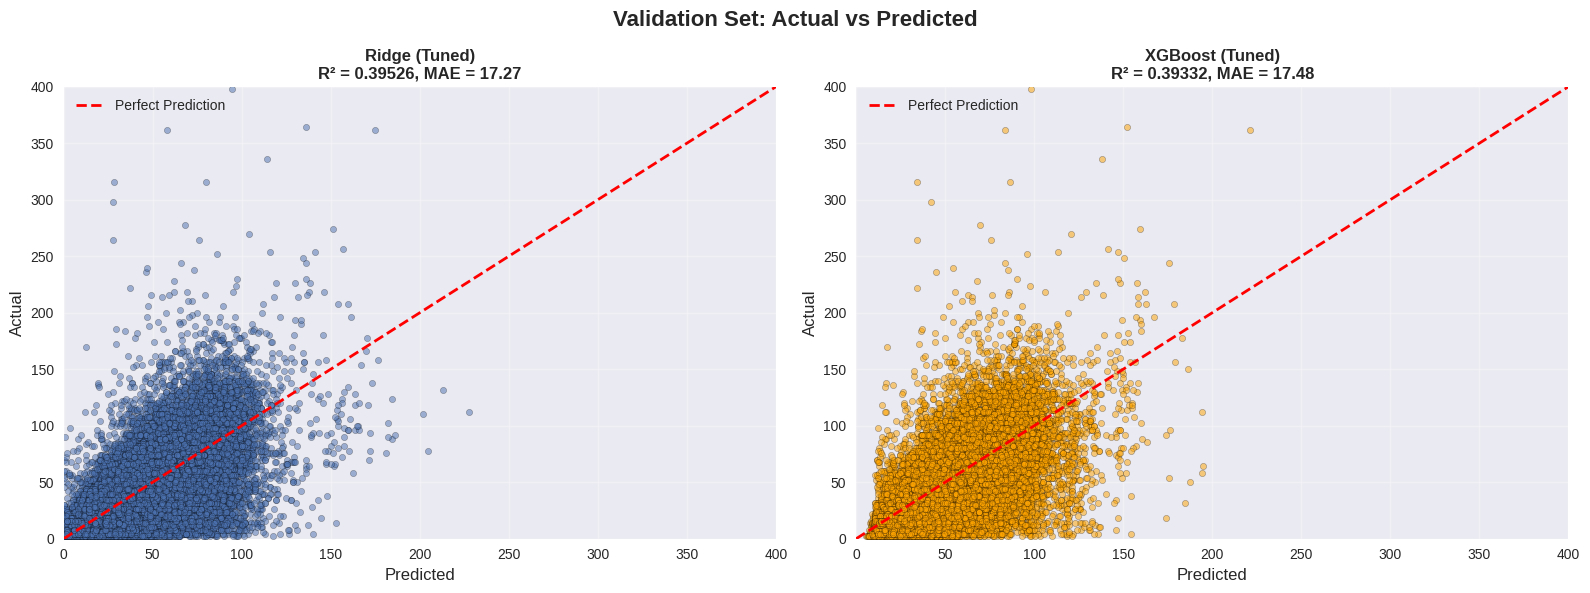

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Validation Set: Actual vs Predicted', fontsize=16, fontweight='bold')

# Ridge Model
ax1 = axes[0]
ax1.scatter(comparison_ridge['audience_count_pred'], comparison_ridge['audience_count_actual'], 
           alpha=0.5, s=20, edgecolors='black', linewidth=0.3)
ax1.plot([0, 400], [0, 400], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlim(0, 400)
ax1.set_ylim(0, 400)
ax1.set_title(f'Ridge (Tuned)\nR² = {r2_ridge:.5f}, MAE = {mae_ridge:.2f}', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# XGBoost Model
ax2 = axes[1]
ax2.scatter(comparison_xgb_tuned['audience_count_pred'], comparison_xgb_tuned['audience_count_actual'], 
           alpha=0.5, s=20, edgecolors='black', linewidth=0.3, color='orange')
ax2.plot([0, 400], [0, 400], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('Actual', fontsize=12)
ax2.set_xlim(0, 400)
ax2.set_ylim(0, 400)
ax2.set_title(f'XGBoost (Tuned)\nR² = {r2_xgb_tuned:.5f}, MAE = {mae_xgb_tuned:.2f}', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### PREPARING FORECASTING HYBRID

In [39]:
# Pure Model Test scores:

# Linear Regression - 0.35635
# Ridge Tuned - 0.35635
# Lasso Tuned - 0.35649
# ElasticNet Tuned - 0.35643
# SGDRegressor Tuned - 0.35024
# XGB Base - 0.35282
# XGB Tuned - 0.37113
# SVR - 0.35218

# Hybrid Model Test scores:

# Tuned XGB with stats - Hybrid weights: 0.80 model + 0.20 baseline - 0.38321
# XGB base with stats - Hybrid weights: 0.6 model + 0.4 baseline - 0.39455

In [40]:
def multi_step_forecast_hybrid(train_data, forecast_dates, forecast_theaters,
                               label_encoder, scaler, model, features,
                               blend_weight_model, blend_weight_baseline):
    """Multi-step forecasting with hybrid prediction"""
    forecast_rows = []
    
    print(f"\nHybrid weights: {blend_weight_model:.2f} model + {blend_weight_baseline:.2f} baseline")
    print(f"\nForecasting {len(forecast_theaters) * len(forecast_dates):,} predictions")
    
    start_time = time.time()
    
    for i, theater_id in enumerate(forecast_theaters):
        theater_id_enc = label_encoder.transform([theater_id])[0]
        history = train_data[train_data['book_theater_id'] == theater_id].sort_values('show_date').copy()
        
        for next_date in forecast_dates:
            row = pd.DataFrame({'book_theater_id': [theater_id], 'show_date': [next_date]})
            row = add_calendar_features(row)
            row['theater_id_encoded'] = theater_id_enc
            
            last_28 = history.tail(28)['audience_count']
            theater_mean = history['audience_count'].mean() if len(history) > 0 else 0
            
            row['lag_7'] = last_28.iloc[-7] if len(last_28) >= 7 else theater_mean
            row['lag_14'] = last_28.iloc[-14] if len(last_28) >= 14 else theater_mean
            row['lag_21'] = last_28.iloc[-21] if len(last_28) >= 21 else theater_mean
            row['lag_28'] = last_28.iloc[-28] if len(last_28) >= 28 else theater_mean
            
            row['same_dow_lag_1w'] = last_28.iloc[-7] if len(last_28) >= 7 else theater_mean
            row['same_dow_lag_2w'] = last_28.iloc[-14] if len(last_28) >= 14 else theater_mean
            row['same_dow_lag_3w'] = last_28.iloc[-21] if len(last_28) >= 21 else theater_mean
            row['same_dow_lag_4w'] = last_28.iloc[-28] if len(last_28) >= 28 else theater_mean
            
            baseline_pred = np.mean([
                row['same_dow_lag_1w'].iloc[0], row['same_dow_lag_2w'].iloc[0],
                row['same_dow_lag_3w'].iloc[0], row['same_dow_lag_4w'].iloc[0]
            ])
            row['same_dow_mean_4w'] = baseline_pred
            
            row['rolling_mean_7'] = last_28.tail(7).mean() if len(last_28) >= 1 else theater_mean
            row['rolling_mean_14'] = last_28.tail(14).mean() if len(last_28) >= 1 else theater_mean
            row['rolling_mean_28'] = last_28.mean() if len(last_28) >= 1 else theater_mean
            
            row = row.fillna(theater_mean)
            
            # Model prediction
            row_scaled = pd.DataFrame(scaler.transform(row[features]), columns=features)
            model_pred = model.predict(row_scaled)[0]
            
            # Hybrid blend
            hybrid_pred = blend_weight_model * model_pred + blend_weight_baseline * baseline_pred
            hybrid_pred = max(hybrid_pred, 0)
            
            row['audience_count'] = hybrid_pred
            history = pd.concat([history, row[['show_date', 'audience_count']]], ignore_index=True)
            forecast_rows.append(row)
    
    elapsed = time.time() - start_time
    print(f"✓ Complete: {elapsed:.1f}s ({elapsed/60:.1f} min)")
    
    return pd.concat(forecast_rows, ignore_index=True)

In [41]:
print("\n" + "OPTIMIZING HYBRID WEIGHTS")
print("="*80)

weight_combinations = [
    (0.9, 0.1),
    (0.8, 0.2),
    (0.7, 0.3),
    (0.6, 0.4),
    (0.5, 0.5),
    (0.4, 0.6)
]

optimized_results = []

for w_model, w_baseline in weight_combinations:
    
    val_forecast = multi_step_forecast_hybrid(
        train_data=train_df,
        forecast_dates=val_dates,
        forecast_theaters=seen_val_theaters,
        label_encoder=label_encoder,
        scaler=scaler_xgb_base,
        model=model_xgb_base,
        features=FEATURES,
        blend_weight_model=w_model,
        blend_weight_baseline=w_baseline,
    )
    
    val_actual = val_df[['book_theater_id', 'show_date', 'audience_count']].copy()
    comparison = val_actual.merge(
        val_forecast[['book_theater_id', 'show_date', 'audience_count']],
        on=['book_theater_id', 'show_date'],
        suffixes=('_actual', '_pred')
    )
    
    r2 = r2_score(comparison['audience_count_actual'], comparison['audience_count_pred'])
    mae = mean_absolute_error(comparison['audience_count_actual'], comparison['audience_count_pred'])
    
    optimized_results.append({
        'Weight_Model': w_model,
        'Weight_Baseline': w_baseline,
        'Val_R2': r2,
        'Val_MAE': mae
    })
    
    print(f"  R²: {r2:.5f}, MAE: {mae:.2f}")

optimized_results_df = pd.DataFrame(optimized_results).sort_values('Val_R2', ascending=False)


OPTIMIZING HYBRID WEIGHTS

Hybrid weights: 0.90 model + 0.10 baseline

Forecasting 49,972 predictions
✓ Complete: 803.3s (13.4 min)
  R²: 0.41050, MAE: 16.77

Hybrid weights: 0.80 model + 0.20 baseline

Forecasting 49,972 predictions
✓ Complete: 821.8s (13.7 min)
  R²: 0.42725, MAE: 16.54

Hybrid weights: 0.70 model + 0.30 baseline

Forecasting 49,972 predictions
✓ Complete: 815.8s (13.6 min)
  R²: 0.43633, MAE: 16.41

Hybrid weights: 0.60 model + 0.40 baseline

Forecasting 49,972 predictions
✓ Complete: 801.9s (13.4 min)
  R²: 0.44005, MAE: 16.37

Hybrid weights: 0.50 model + 0.50 baseline

Forecasting 49,972 predictions
✓ Complete: 783.2s (13.1 min)
  R²: 0.43456, MAE: 16.43

Hybrid weights: 0.40 model + 0.60 baseline

Forecasting 49,972 predictions
✓ Complete: 800.6s (13.3 min)
  R²: 0.42256, MAE: 16.59


In [42]:
print("\n" + "HYBRID WEIGHT OPTIMIZATION RESULTS")
print("="*80)

print(optimized_results_df.to_string(index=False))

best_idx = optimized_results_df['Val_R2'].idxmax()
best_weight_model = optimized_results_df.loc[best_idx, 'Weight_Model']
best_weight_baseline = optimized_results_df.loc[best_idx, 'Weight_Baseline']
best_val_r2 = optimized_results_df.loc[best_idx, 'Val_R2']

print(f"\nBest weights: {best_weight_model:.1f} model + {best_weight_baseline:.1f} baseline")
print(f"Best Validation R²: {best_val_r2:.5f}")


HYBRID WEIGHT OPTIMIZATION RESULTS
 Weight_Model  Weight_Baseline   Val_R2   Val_MAE
          0.6              0.4 0.440054 16.370994
          0.7              0.3 0.436329 16.414212
          0.5              0.5 0.434559 16.433410
          0.8              0.2 0.427248 16.538558
          0.4              0.6 0.422564 16.590698
          0.9              0.1 0.410504 16.772252

Best weights: 0.6 model + 0.4 baseline
Best Validation R²: 0.44005


#### TRAINING FINAL MODEL ON FULL DATA

In [43]:
print("\n" + "BUILDING TRAINING FEATURES ON FULL DATA")
print("="*80)

master_df = booknow_visits_cleaned.copy()
master_df = add_calendar_features(master_df)

label_encoder_full = LabelEncoder()
master_df['theater_id_encoded'] = label_encoder_full.fit_transform(master_df['book_theater_id'])

master_df = add_robust_lag_features(master_df)

X_full = master_df[FEATURES]
y_full = master_df['audience_count']

xgb_pipeline.fit(X_full, y_full)

scaler_full = xgb_pipeline.named_steps['scaler']
model_full = xgb_pipeline.named_steps['model']

print("✓ Final pipeline trained on full data")


BUILDING TRAINING FEATURES ON FULL DATA
✓ Final pipeline trained on full data


### TEST FORECASTING

In [44]:
print("\n" + "PREPARING TEST FEATURES")
print("="*80)

test_df = sample_submission.copy()
test_df[['book_theater_id', 'show_date']] = test_df['ID'].str.rsplit('_', n=1, expand=True)
test_df['show_date'] = pd.to_datetime(test_df['show_date'])

test_dates = sorted(test_df['show_date'].unique())
test_theaters = set(test_df['book_theater_id'].unique())
train_theaters = set(master_df['book_theater_id'].unique())
seen_test_theaters = list(test_theaters.intersection(train_theaters))

print(f"Test theaters: {len(test_theaters)}")
print(f"Seen in training: {len(seen_test_theaters)}")


PREPARING TEST FEATURES
Test theaters: 827
Seen in training: 817


In [45]:
forecast_df = multi_step_forecast_hybrid(
    train_data=master_df,
    forecast_dates=test_dates,
    forecast_theaters=seen_test_theaters,
    label_encoder=label_encoder_full,
    scaler=scaler_full,
    model=model_full,
    features=FEATURES,
    blend_weight_model=best_weight_model,
    blend_weight_baseline=best_weight_baseline,
)


Hybrid weights: 0.60 model + 0.40 baseline

Forecasting 43,301 predictions
✓ Complete: 711.3s (11.9 min)


### SUBMISSION

In [46]:
# Create submission
test_df.drop(columns=['audience_count'], inplace=True, errors='ignore')
submission = test_df.merge(forecast_df[['book_theater_id', 'show_date', 'audience_count']],
                         on=['book_theater_id', 'show_date'], how='left')

# Global fallback for unseen theaters
train_cal = add_calendar_features(booknow_visits_cleaned)
baseline = train_cal.groupby('day_of_week')['audience_count'].mean()

submission['day_of_week'] = submission['show_date'].dt.dayofweek
submission['audience_count'] = submission['audience_count'].fillna(submission['day_of_week'].map(baseline))
submission['audience_count'] = submission['audience_count'].fillna(booknow_visits_cleaned['audience_count'].mean())
submission['audience_count'] = submission['audience_count'].clip(lower=0)

# Save
submission[['ID', 'audience_count']].to_csv('submission.csv', index=False)

print("Submission saved: submission.csv")

Submission saved: submission.csv
